In [55]:
#library
import os
from datetime import datetime
import time
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import math

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from itertools import product

import warnings
warnings.filterwarnings("ignore")
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

info = pd.read_csv("g-research-crypto-forecasting/asset_details.csv")
ctrain = pd.read_csv("g-research-crypto-forecasting/train.csv")

# 데이터 살펴보기

In [56]:
info

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


In [57]:
ctrain.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [58]:
ctrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   Asset_ID   int64  
 2   Count      float64
 3   Open       float64
 4   High       float64
 5   Low        float64
 6   Close      float64
 7   Volume     float64
 8   VWAP       float64
 9   Target     float64
dtypes: float64(8), int64(2)
memory usage: 1.8 GB


In [59]:
# Impute Missing Time Value
def c_time_sub(asset_id, data=ctrain):
    df=data[ctrain["Asset_ID"]==asset_id].set_index("timestamp")
    df=df.reindex(range(df.index[0],df.index[-1]+60,60), method="pad")
    return df

# Subgroup Bitcoin
btc=c_time_sub(asset_id=1)
(btc.index[1:] -btc.index[:-1]).value_counts().head()

# Subgroup Ethereum
eth=c_time_sub(asset_id=6)
(btc.index[1:] -btc.index[:-1]).value_counts().head()

# Subgroup Cardano
ada=c_time_sub(asset_id=3)
(ada.index[1:] -ada.index[:-1]).value_counts().head()

60    1803769
Name: timestamp, dtype: int64

In [60]:
# time frame selection: from datetime to timestamp
totimestamp= lambda s: np.int32(time.mktime(datetime.strptime(s,"%d/%m/%Y").timetuple()))

# Log Return 
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

In [61]:
# Data Selection
def crypto_sub(asset_id ,data= ctrain ):
    df = data[data["Asset_ID"]==asset_id].reset_index(drop = True)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df = df.set_index('timestamp')
    return df

#Subgroup Bitcoin
btc1=crypto_sub(asset_id=1)

#Subgroup Eth
eth1=crypto_sub(asset_id=6)

#Subgroup Ada
ada1=crypto_sub(asset_id=3)

In [62]:
btc1

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
2018-01-01 00:01:00,1,229.0,13835.194000,14013.800000,13666.11,13850.176000,31.550062,13827.062093,-0.014643
2018-01-01 00:02:00,1,235.0,13835.036000,14052.300000,13680.00,13828.102000,31.046432,13840.362591,-0.015037
2018-01-01 00:03:00,1,528.0,13823.900000,14000.400000,13601.00,13801.314000,55.061820,13806.068014,-0.010309
2018-01-01 00:04:00,1,435.0,13802.512000,13999.000000,13576.28,13768.040000,38.780529,13783.598101,-0.008999
2018-01-01 00:05:00,1,742.0,13766.000000,13955.900000,13554.44,13724.914000,108.501637,13735.586842,-0.008079
...,...,...,...,...,...,...,...,...,...
2021-09-20 23:56:00,1,1940.0,42983.780000,43001.850849,42878.26,42899.012857,56.850913,42935.489499,NaN
2021-09-20 23:57:00,1,2026.0,42904.197143,42932.000000,42840.16,42860.005714,80.993326,42879.576084,NaN
2021-09-20 23:58:00,1,1986.0,42859.385714,42887.500000,42797.20,42827.020000,65.677734,42844.090693,NaN


# 데이타 시각화

In [63]:
%matplotlib inline
info_s=info.sort_values("Weight")
fig_index=px.bar(info_s,x="Asset_Name" , y="Weight", color="Weight", title="Popular Cryptocurrency Weight Distribution")
fig_index.show()

From the Correlation plot we can see Bitcoin Cash is highly correlated with EOS.IO.  

Binance Coin is correlated with many crypto currencies, such as , Bitcoin, Bitcoin Cash, Cardano, Ethereum.

We can have a roughly conclude that Binance Coin, Bitcoin Cash prices have a strong relation with other cryptocurrencies. Whereas Dogecoin and Monero prices are quite independent. Ealier we mentioned Monero is based a donation, which makes sense it is not correlated so much with other coins.

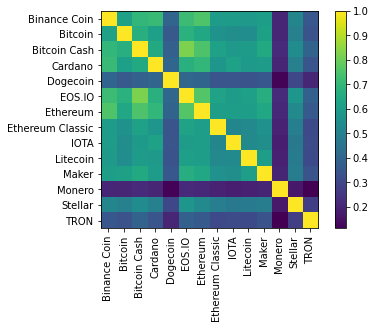

In [64]:
# time frame selection: from datetime to timestamp
totimestamp= lambda s: np.int32(time.mktime(datetime.strptime(s,"%d/%m/%Y").timetuple()))

# Log Return 
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

all2021=pd.DataFrame([])
for asset_id, asset_name in zip(info.Asset_ID, info.Asset_Name):
    asset=ctrain[ctrain["Asset_ID"]==asset_id].set_index("timestamp")
    asset=asset.loc[totimestamp("01/01/2021"):totimestamp("21/09/2021")]
    asset=asset.reindex(range(asset.index[0],asset.index[-1]+60,60), method="pad")
    lret=log_return(asset.Close.fillna(0))[1:]
    all2021=all2021.join(lret,rsuffix=asset_name,how="outer")
    
plt.imshow(all2021.corr());
plt.yticks(info.Asset_ID, info.Asset_Name.values)
plt.xticks(info.Asset_ID, info.Asset_Name.values,rotation="vertical");
plt.colorbar()

In [65]:
# Impute Missing Time Value
def c_time_sub(asset_id, data=ctrain):
    df=data[ctrain["Asset_ID"]==asset_id].set_index("timestamp")
    df=df.reindex(range(df.index[0],df.index[-1]+60,60), method="pad")
    return df

In [66]:
#1. Subgroup Bitcoin
btc=c_time_sub(asset_id=1)
(btc.index[1:] -btc.index[:-1]).value_counts().head()
btc.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1514764860,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
1514764920,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
1514764980,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309
1514765040,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999
1514765100,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079


In [67]:
#2. Subgroup Ethereum
eth=c_time_sub(asset_id=6)
(btc.index[1:] -btc.index[:-1]).value_counts().head()
eth.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1514764860,6,173.0,738.3025,746.00,732.51,738.5075,335.987856,738.839291,-0.004809
1514764920,6,192.0,738.5075,745.14,732.49,738.2600,232.793141,738.268967,-0.004441
1514764980,6,120.0,738.3325,745.12,730.00,737.5025,174.138031,737.994457,-0.004206
1514765040,6,156.0,737.2225,744.69,728.93,737.1025,165.383926,737.303631,-0.002205
1514765100,6,118.0,736.5300,743.80,727.11,735.7050,193.078039,736.163026,-0.001744


In [68]:
#3. Subgroup Cardano
ada=c_time_sub(asset_id=3)
(ada.index[1:] -ada.index[:-1]).value_counts().head()
ada.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1523956260,3,16.0,0.260000,0.260990,0.260000,0.260000,32230.832200,0.260200,-0.004612
1523956320,3,28.0,0.260000,0.260990,0.259852,0.260000,18711.228600,0.260037,0.000387
1523956380,3,9.0,0.260000,0.260000,0.258700,0.258700,6831.405700,0.259515,-0.005415
1523956440,3,5.0,0.259999,0.259999,0.259870,0.259998,4414.874062,0.259884,-0.005415
1523956500,3,9.0,0.259997,0.259997,0.259000,0.259997,10797.813800,0.259997,0.000385


In [69]:
# Create time interval for 2021
def dur(start,end,data):
    df=data.loc[totimestamp(start): totimestamp(end)]
    return df

btc2021= dur(start="01/01/2021", end="21/09/2021", data=btc)
eth2021= dur(start="01/01/2021", end="21/09/2021", data=eth)
ada2021= dur(start="01/01/2021", end="21/09/2021", data=ada)

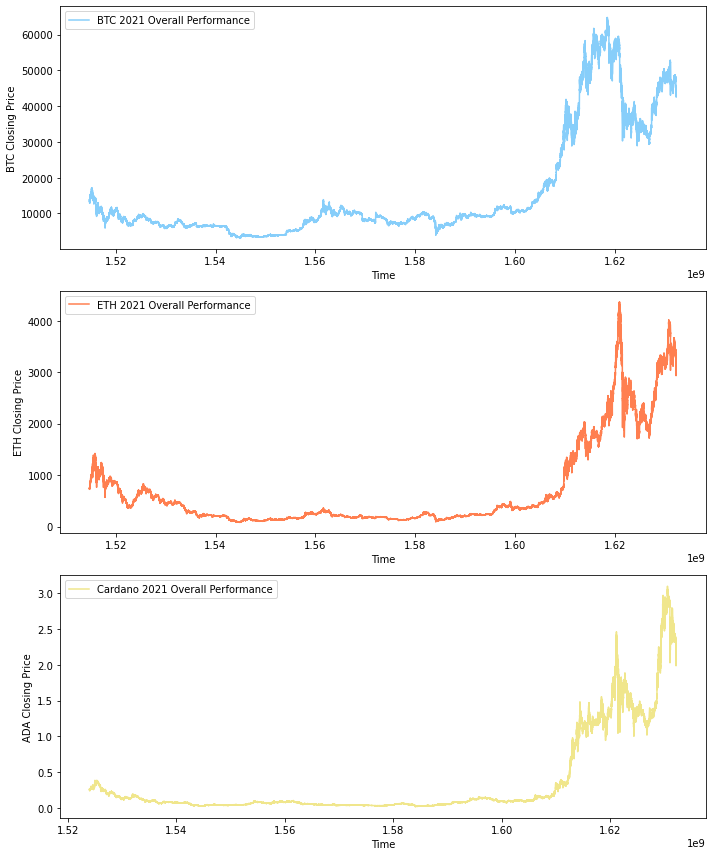

In [70]:
# Plot the Closing Price for BTC, ETH, ADA
f= plt.figure(figsize=(10,12))  

def gplot(no , data, price, label, ylabel, color):
    ax=f.add_subplot(no)
    plt.plot(data[price], label=label, color=color)
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    return plt

gplot(no=311, data=btc, price="Close" , label="BTC 2021 Overall Performance", ylabel="BTC Closing Price", color="Lightskyblue")
gplot(no=312, data=eth, price="Close" ,label="ETH 2021 Overall Performance", ylabel="ETH Closing Price", color="Coral")
gplot(no=313, data=ada, price="Close" ,label="Cardano 2021 Overall Performance", ylabel="ADA Closing Price", color="khaki")

plt.tight_layout()
plt.show()


Return Rate for BTC, ETH, and ADA

we see the crypto currency price went up dramatically regardless of the type, we would like to investigate one step further for the Target variable. *Target : 15 minute resudualized returns.

*Residual Return: An asset's residual return equals its excess return minus beta times the benchmark excess return.

As we can see ETH, and BTC residual return are relatively stable compared to ADA. This might be a good implication that if the investor would take short time trading opportunities, ADA is a better choice.

If the investor is risk averse, BTC or ETH will be a better fit

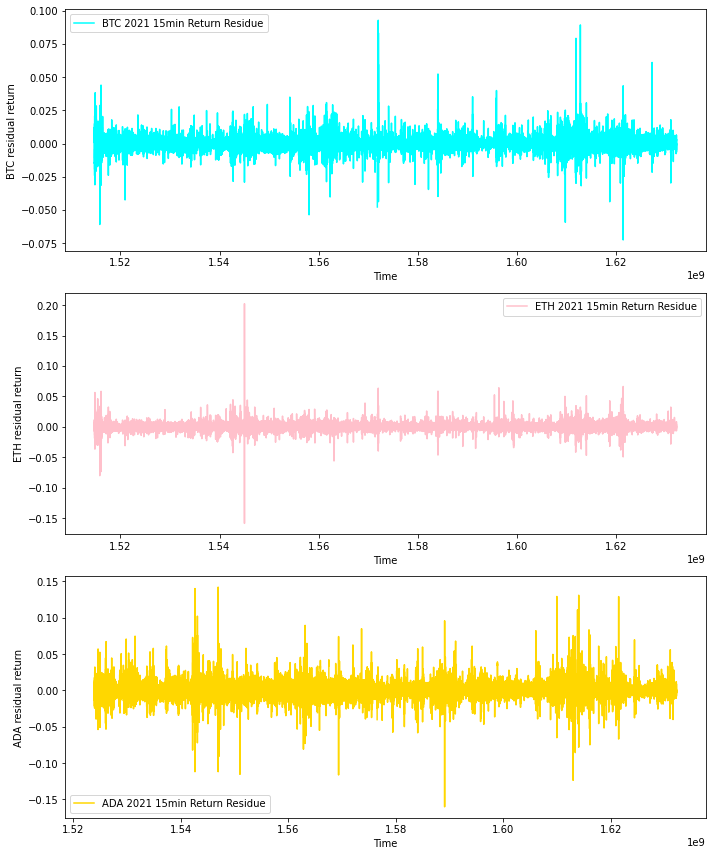

In [71]:

f= plt.figure(figsize=(10,12))  
gplot(no=311, data=btc, price="Target" , label="BTC 2021 15min Return Residue", ylabel="BTC residual return", color="Aqua")
gplot(no=312, data=eth, price="Target" ,label="ETH 2021 15min Return Residue", ylabel="ETH residual return", color="Pink")
gplot(no=313, data=ada, price="Target" ,label="ADA 2021 15min Return Residue", ylabel="ADA residual return", color="gold")


plt.tight_layout()
plt.show()

In [72]:
def c_chart(data,label):
    candlestick = go.Figure(data = [go.Candlestick(x =data.index, 
                                               open = data[('Open')], 
                                               high = data[('High')], 
                                               low = data[('Low')], 
                                               close = data[('Close')])])
    candlestick.update_xaxes(title_text = 'Time',
                             rangeslider_visible = True)

    candlestick.update_layout(
    title = {
        'text': '{:} Candelstick Chart'.format(label),
        "y":0.8,
        "x":0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

    candlestick.update_yaxes(title_text = 'Price in USD', ticksuffix = '$')
    return candlestick

btc1.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
2018-01-01 00:01:00,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
2018-01-01 00:02:00,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
2018-01-01 00:03:00,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309
2018-01-01 00:04:00,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999
2018-01-01 00:05:00,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079


In [73]:
%matplotlib inline
btc_candle=c_chart(btc1[-90:], label="BTC Price")
btc_candle.show()

# 모델링

In [74]:
# Function to Subset the Price variables
def mini_data(data):
    df=data[["Close","Low","High","Open"]]
    return df

btc1_mini=mini_data(btc1)
eth1_mini=mini_data(eth1)
ada1_mini=mini_data(ada1)
btc1.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
2018-01-01 00:01:00,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
2018-01-01 00:02:00,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
2018-01-01 00:03:00,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309
2018-01-01 00:04:00,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999
2018-01-01 00:05:00,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079


BTC Seasonal Decomposition


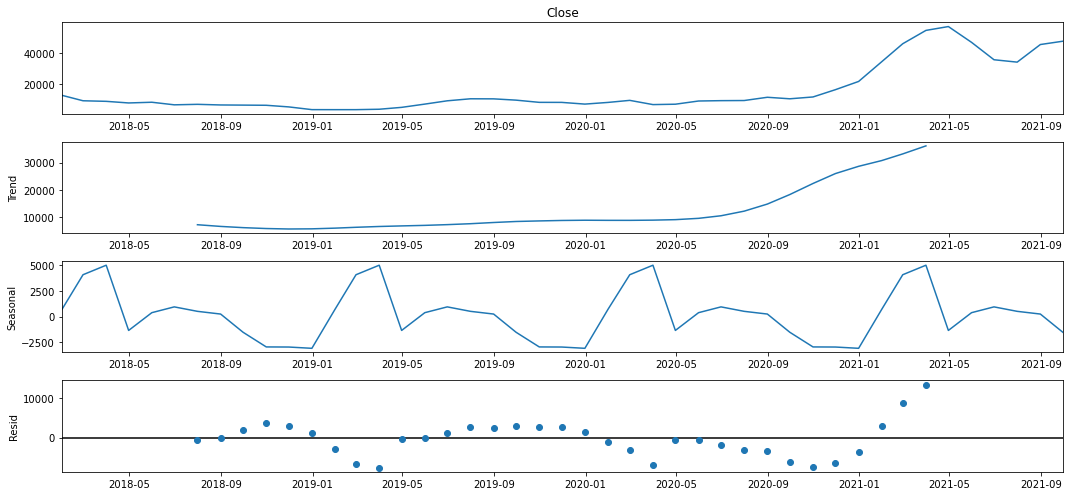

In [86]:
# Function to Plot
plt.rcParams["figure.figsize"]=(15,7)

def season_df(data, label):
    df=data.resample("M").mean()
    seasonal_decompose(df.Close).plot()
    print(label)
    return plt.show()

season_df(data=btc1_mini, label="BTC Seasonal Decomposition")

In [87]:
#Box-Cox Transformation
btc_month=btc1_mini.resample("M").mean()
btc_month["close_box"], lmbda=stats.boxcox(btc_month.Close)

#btc_month['close_box'], lmbda = stats.boxcox(btc_month.Close)

In [88]:
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [89]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

  parameters         aic
3     (1, 0) -446.108741
1     (0, 1) -445.320464
6     (2, 0) -444.145513
4     (1, 1) -444.129700
2     (0, 2) -442.735646
                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   45
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 225.054
Date:                Sun, 26 Dec 2021   AIC                           -446.109
Time:                        15:16:22   BIC                           -442.540
Sample:                    01-31-2018   HQIC                          -444.785
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3821      0.133      2.874      0.004      

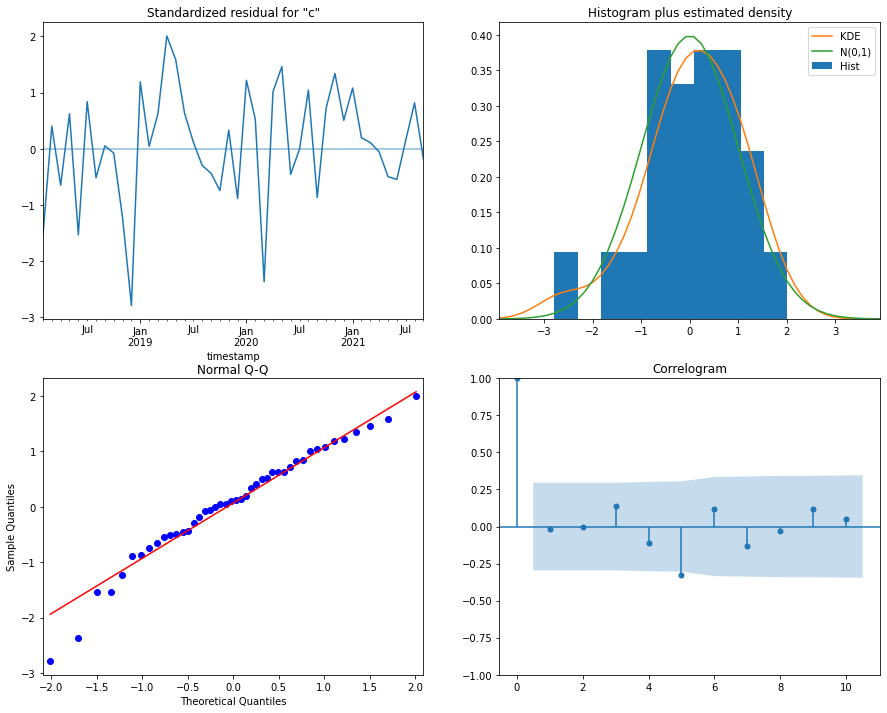

In [90]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()
#https://leedakyeong.tistory.com/entry/ARIMA%EB%9E%80-ARIMA-%EB%B6%84%EC%84%9D%EA%B8%B0%EB%B2%95-AR-MA-ACF-PACF-%EC%A0%95%EC%83%81%EC%84%B1%EC%9D%B4%EB%9E%80

In [91]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

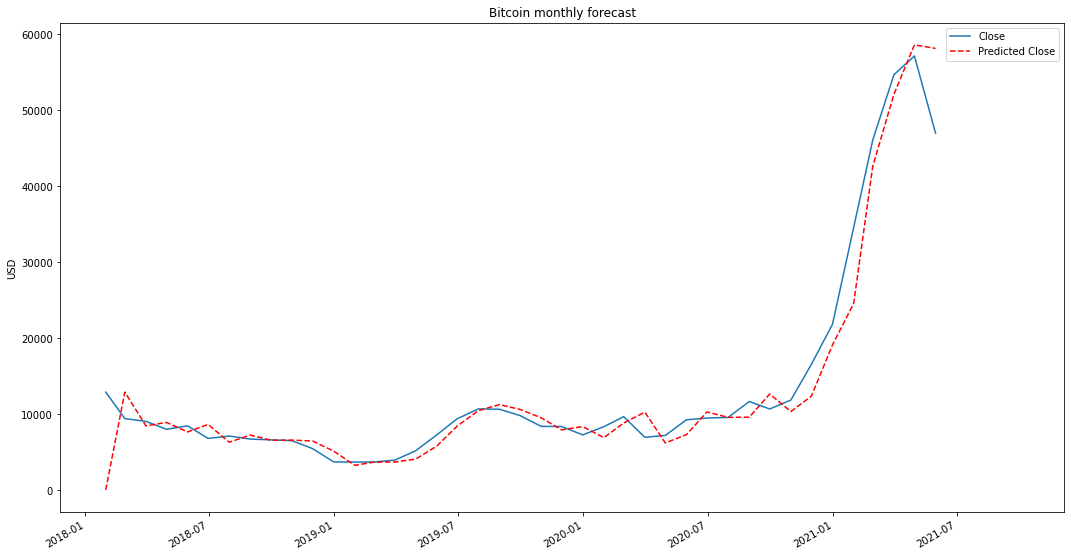

In [92]:
# Prediction
btc_month_pred = btc_month[['Close']]
date_list = [datetime(2021, 6, 20), datetime(2021, 7, 20), datetime(2021, 8, 21), datetime(2021, 9, 21)]
future = pd.DataFrame(index=date_list, columns= btc_month.columns)
btc_month_pred = pd.concat([btc_month_pred, future])
btc_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2018, 1, 31), end=datetime(2021, 5, 31)), lmbda)
plt.figure(figsize=(18,10))
btc_month_pred.Close.plot()
btc_month_pred.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')
plt.show()

# RandomForestRegressor

In [54]:
train = pd.read_csv("g-research-crypto-forecasting/train.csv")
print(train.size)

train.replace([np.inf, -np.inf], np.nan, inplace=True)
train.dropna(inplace=True)
print(train.size)

# take a sample of the training data
train = train.sample(frac=0.001)
print(train.size)

242368060
234864590
234860


In [30]:
def upper_shadow(df):
    return df['High'] - np.maximum(df['Close'], df['Open'])

def lower_shadow(df):
    return np.minimum(df['Close'], df['Open']) - df['Low']

# Helper function for adding all the engineered features
def feature_engineering(df):
    df['Upper_Shadow'] = upper_shadow(df)
    df['Lower_Shadow'] = lower_shadow(df)
    return df

#train = feature_engineering(train)

In [33]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1)
model.fit(train[['Asset_ID', 'Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']].values, train['Target'].values)
#model.fit(train[['Asset_ID', 'Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Upper_Shadow', 'Lower_Shadow']].values, train['Target'].values)

RandomForestRegressor(n_jobs=-1)

In [36]:
val = pd.read_csv("g-research-crypto-forecasting/supplemental_train.csv")
val.replace([np.inf, -np.inf], np.nan, inplace=True)
val.dropna(inplace=True)

# take a sample of the training data
val = val.sample(frac=0.001)
print(val.size)

val

20130


,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
1644689,1630594680,2,441.0,660.564000,661.08000,659.830000,660.606000,5.809743e+02,660.337269,-0.001434
333065,1624970520,6,1253.0,2184.242857,2185.50000,2180.690000,2182.612857,8.605087e+02,2182.748768,0.002162
915883,1627470720,4,470.0,0.210524,0.21070,0.210250,0.210572,1.487486e+06,0.210491,-0.003464
1369668,1629415860,12,226.0,0.365416,0.36581,0.364203,0.364744,1.763290e+05,0.364948,0.003340
699278,1626541440,7,69.0,40.955667,40.97600,40.912000,40.933100,6.807217e+02,40.944350,0.000948
...,...,...,...,...,...,...,...,...,...,...
1027612,1627949820,7,154.0,50.866080,50.98300,50.833000,50.928520,1.460977e+03,50.903841,0.000487
1233160,1628830860,0,109.0,393.740000,394.01100,393.594000,394.000000,3.233159e+02,393.989584,0.004575
391856,1625222580,12,107.0,0.254638,0.25498,0.254260,0.254684,9.579455e+04,0.254554,0.001555
503146,1625699760,5,262.0,3.842017,3.84900,3.839500,3.845891,2.878032e+04,3.843746,-0.000873


In [38]:
from sklearn.metrics import mean_squared_error

column_names = list(val.columns.values.tolist())
column_names.remove('Target')
column_names.remove('timestamp')

np.sqrt(mean_squared_error(val['Target'], model.predict(val[column_names])))

0.004404709590341301

In [ ]:
# Start to predict
import math

import gresearch_crypto
env = gresearch_crypto.make_env()   # initialize the environment

def predict(row):
    row = feature_engineering(row)
    p_val = model.predict([row[['Asset_ID', 'Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Upper_Shadow', 'Lower_Shadow']].values])[0]
    return p_val

iter_test = env.iter_test()    # an iterator which loops over the test set and sample submission
for (test_df, sample_prediction_df) in iter_test:
    sample_prediction_df['Target'] = test_df.apply(lambda row: predict(row), axis = 1)
    #print(sample_prediction_df)
    #sample_prediction_df['Target'] = 0  # make your predictions here
    env.predict(sample_prediction_df)   # register your predictions
    